In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
data = pd.read_csv('DATA_PROVINSI.csv')

df = pd.DataFrame(data)

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Menambahkan kolom lag (pergeseran)
df['jumlah_kecelakaan_lag'] = df['jumlah_kecelakaan'].shift(1)
df = df.dropna() # Menghapus baris dengan nilai NaN

In [3]:
# Memisahkan data latih dan data uji sesuai rasio (0.8 untuk 80:20)
train_size = int(0.7 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Memisahkan fitur dan target untuk data latih
X_train = train_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_train = train_data['jumlah_kecelakaan'].values

# Memisahkan fitur dan target untuk data uji
X_test = test_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_test = test_data['jumlah_kecelakaan'].values

In [4]:
# Define evaluation function
def evaluate(individual):
    epsilon, C, gamma = individual
    
    if epsilon <= 0 or C <= 0 or gamma <= 0:
        return float('inf'),
    
    svr = SVR(epsilon=epsilon, C=C, gamma=gamma)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    return mape,

C range=(0.0001, 0.01): 24.3703
C range=(0.0001, 0.1): 24.0835
C range=(0.01, 1): 24.1722
C range=(0.01, 5): 24.1697
C range=(1, 5): 24.0343
C range=(1, 10): 24.1655
C range=(10, 25): 24.0328
C range=(10, 50): 24.0330

Rentang C optimal: (10, 25)
MAPE terbaik: 24.0328
[0.41141498611895555, 12.634684207016413, 0.006019487225272228]


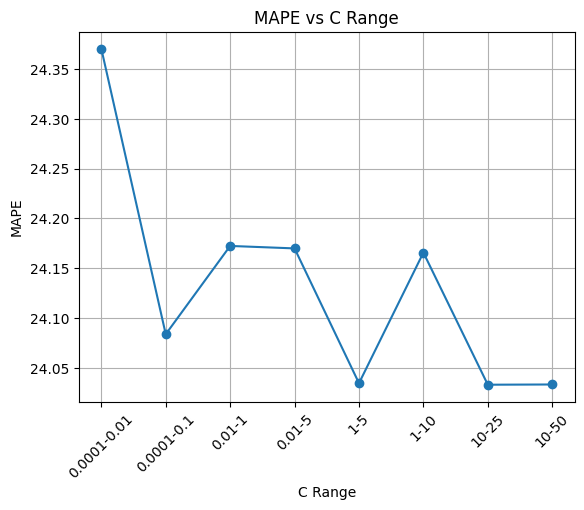

In [5]:
def main():
    # Setup DEAP framework
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    
    epsilon_range = (0.001, 5)
    C_ranges = [(0.0001, 0.01), (0.0001, 0.1), (0.01, 1), (0.01, 5), (1, 5), (1, 10), (10, 25), (10, 50)]
    gamma_range = (1e-07, 5)
    
    def create_individual(C_range):
        epsilon = random.uniform(*epsilon_range)
        C = random.uniform(*C_range)
        gamma = random.uniform(*gamma_range)
        return creator.Individual([epsilon, C, gamma])
    
    toolbox.register("individual", create_individual, C_ranges[0])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Menggunakan crossover uniform 
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Menggunakan mutasi gaussian
    toolbox.register("select", tools.selTournament, tournsize=3) # Menggunakan seleksi turnamen
    toolbox.register("evaluate", evaluate)
    
    population_size = 240
    num_generations = 90
    crossover_rate = 0
    mutation_rate = 1

    results = []
    
    for C_range in C_ranges:
        toolbox.unregister("individual")
        toolbox.register("individual", create_individual, C_range)
        population = toolbox.population(n=population_size)

        for generation in range(num_generations):
            offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
            for ind in offspring:
                ind[0] = max(min(ind[0], epsilon_range[1]), epsilon_range[0])
                ind[1] = max(min(ind[1], max(C_range)), min(C_range))
                ind[2] = max(min(ind[2], gamma_range[1]), gamma_range[0])
                
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit

            population = toolbox.select(offspring, k=len(population))

        best_individual = tools.selBest(population, k=1)[0]
        mape = best_individual.fitness.values[0]

        results.append((C_range, mape))
        print(f"C range={C_range}: {mape:.4f}")

    best_result = min(results, key=lambda x: x[1])
    best_C_range = best_result[0]
    best_mape = best_result[1]

    print(f"\nRentang C optimal: {best_C_range}")
    print(f"MAPE terbaik: {best_mape:.4f}")
    print(best_individual)
    
    # Plot hasil
    fig, ax = plt.subplots()
    C_ranges_str = [f"{r[0]}-{r[1]}" for r in C_ranges]
    mapes = [r[1] for r in results]
    ax.plot(C_ranges_str, mapes, marker='o')
    ax.set_xlabel('C Range')
    ax.set_ylabel('MAPE')
    ax.set_title('MAPE vs C Range')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

if __name__ == "__main__":
    main()